# Musical genre handling

In [2]:
import pandas as pd
import numpy as np
import mpld3
import re
import math
import matplotlib.pyplot as plt
from datetime import datetime

#### Definition of useful functions

In [4]:
#https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows
def tidy_split(df, column, sep='|', keep=False):
    """
    Split the values of a column and expand so the new DataFrame has one split
    value per row. Filters rows where the column is missing.

    Params
    ------
    df : pandas.DataFrame
        dataframe with the column to split and expand
    column : str
        the column to split and expand
    sep : str
        the string used to split the column's values
    keep : bool
        whether to retain the presplit value as it's own row

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns as `df`.
    """
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            value = re.sub("[\[\]\']", '', value)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df

## Work on musical genres

In [3]:
dataset = pd.read_json("json/corpus.json")
dataset = dataset.reset_index().drop(columns = ['index'])

In [5]:
dataset.head()

,track_id,title_billboard,artist_billboard,title_spotify,artist_spotify,key,time_signature,mode,tempo,loudness,duration_ms,energy,valence,genre_list,weeks_list,ranks_list,highest_rank
0,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,"[adult standards, brill building pop, bubblegu...",[1958-08-08],[1],1
1,205EtD8tQnHDXMkmtYiaHF,Patricia,Perez Prado And His Orchestra,Patricia,Pérez Prado,1,4,1,137.396,-9.522,140867,0.638,0.837,"[bolero, cuban rumba, latin jazz, lounge, mamb...",[1958-08-08],[3],3
2,1TRBNskaco4d6OQ9uVY7rz,Ginger Bread,Frankie Avalon,Ginger Bread,Frankie Avalon,8,4,1,147.226,-12.136,123653,0.623,0.976,"[adult standards, brill building pop, christma...",[1958-08-08],[15],15
3,6fb0Yo4q22mmf0XCkIh2dO,Susie Darlin',Robin Luke,Susie Darlin' - Re-Recording,Robin Luke,9,4,1,123.094,-13.681,153920,0.325,0.816,[],[1958-08-08],[42],42
4,0dc0eU5THc1uE0Q0KV73XN,"Please Help Me, I'm Falling",Hank Locklin,"Please Help Me, I'm Falling",Hank Locklin,7,4,1,105.479,-10.712,141467,0.336,0.553,"[country gospel, cowboy western, nashville sou...","[1960-05-22, 1960-06-01, 1960-06-08, 1960-06-1...","[77, , 42, , 38, , 34, , 24, , 16, ...",


In [6]:
genre = dataset
#count the total number of weeks the song remains on the chart
for i, row in genre.iterrows():
    genre.loc[i,'weeks_on_chart'] = len(row['ranks_list'])

In [7]:
genre = genre.loc[genre['weeks_on_chart'] >= 1]

In [8]:
#split the different possible genres given for each song into unique rows
genre = tidy_split(genre,'genre_list', sep=',')

### Basic statistics

In [9]:
genre_rank = genre.groupby(['genre_list']).count()
print("----Total number of different genres : "+ str(len(genre_rank)))

----Total number of different genres : 987


In [10]:
genre_rank = genre_rank.sort_values(['title_spotify'],ascending=False)
genre_mains = genre_rank[genre_rank['weeks_list']>1]
genre_mains = genre_mains.reset_index()
genre_mains = genre_mains.loc[(genre_mains['genre_list'] != 'nan') & (genre_mains['genre_list'] != '')]
genre_mains_list = genre_mains["genre_list"].tolist()
genre_to_plot = genre[genre['genre_list'].isin(genre_mains_list)]

Musical genres rank

In [11]:
genre_mains.head(10)

,genre_list,track_id,title_billboard,artist_billboard,title_spotify,artist_spotify,key,time_signature,mode,tempo,loudness,duration_ms,energy,valence,weeks_list,ranks_list,highest_rank,weeks_on_chart
0,adult standards,3695,3695,3695,3695,3695,3695,3695,3695,3695,3695,3695,3695,3695,3695,3695,3695,3695
1,mellow gold,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635
2,soft rock,3287,3287,3287,3287,3287,3287,3287,3287,3287,3287,3287,3287,3287,3287,3287,3287,3287
3,folk rock,2978,2978,2978,2978,2978,2978,2978,2978,2978,2978,2978,2978,2978,2978,2978,2978,2978
5,christmas,2914,2914,2914,2914,2914,2914,2914,2914,2914,2914,2914,2914,2914,2914,2914,2914,2914
6,rock,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863
7,soul,2461,2461,2461,2461,2461,2461,2461,2461,2461,2461,2461,2461,2461,2461,2461,2461,2461
8,motown,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452
9,brill building pop,2287,2287,2287,2287,2287,2287,2287,2287,2287,2287,2287,2287,2287,2287,2287,2287,2287
10,classic rock,2065,2065,2065,2065,2065,2065,2065,2065,2065,2065,2065,2065,2065,2065,2065,2065,2065


In [300]:
array = []
for i, row in genre_to_plot.iterrows():
    array.append(datetime.strptime(row['weeks_list'][0], '%Y-%m-%d').year)
genre_to_plot['year'] = array

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [301]:
genre_to_plot = genre_to_plot.sort_values(['year', 'genre_list'],ascending=True)

In [302]:
import plotly.plotly as py
import plotly.graph_objs as go

import plotly
import plotly.graph_objs as go


# Create a trace
trace = go.Scatter(
    x = genre_to_plot[:]['year'],
    y = genre_to_plot[:]['genre_list'],
    mode = 'markers'
)


data = [trace]

# Plot and embed in ipython notebook!
#py.iplot(data, filename='basic-scatter')
#plot_url = py.plot(data, filename='basic-line')
plotly.offline.plot({
    "data": data,
    "layout": go.Layout(title="Music genre")
}, auto_open=True)

'file:///Users/bernasconi/Documents/EPFL/Digital Musicology/digital_musicology/temp-plot.html'

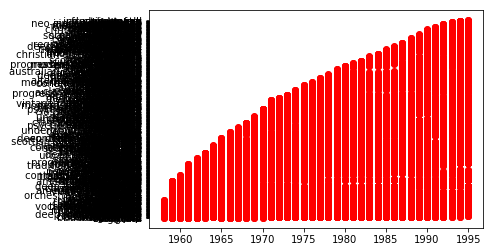

In [303]:
plt.plot(genre_to_plot[:]['year'], genre_to_plot[:]['genre_list'], 'ro')

plt.show()

In [345]:
main_genres = {
    "pop": ['pop', 'merseybeat'],
    "rock": ['rock'],
    "country": ['country', 'cowboy western', 'nashville sound'],
    "reggae": ['reggae'],
    "electro": ['electro'],
    "disco": ['disco','funk'],
    "soul": ['soul'],
    "r&b": ['r&b', 'urban contemporary'],
    "metal": ['metal', 'hard rock', 'psychedelic rock', 'grunge'],
    "blues": ['blues', 'doo-wop'],
    "jazz": ['jazz'],
    "folk": ['folk'],
    "christmas": ['christmas'],
    "adult standards": ['adult standards'],
    "hiphop": ['hip hop']
}
#blues, classical, country, disco, hiphop, jazz, reggae, rock, metal and pop

In [309]:
genre_to_plot.groupby(['year','genre_list']).count()

track_id  title_billboard  artist_billboard  \
year genre_list                                                           
1958  ballroom                     1                1                 1   
      big band                     1                1                 1   
      bluegrass                    3                3                 3   
      blues-rock                   1                1                 1   
      bolero                       2                2                 2   
      brill building pop          30               30                30   
      bubblegum pop                7                7                 7   
      canadian pop                 1                1                 1   
      chicago blues                1                1                 1   
      christmas                   42               42                42   
      classic girl group           1                1                 1   
      classic soul                 2                2                 2   
      country gospel               6                6                 6   
      cowboy western               9                9                 9   
      cuban rumba                  1                1                 1   
      deep adult standards         7                7                 7   
      doo-wop                     23               23                23   
      easy listening              16               16                16   
      electric blues               1                1                 1   
      folk rock                   10               10                10   
      harmonica blues              1                1                 1   
      italian pop                  1                1                 1   
      jazz blues                   1                1                 1   
      latin jazz                   1                1                 1   
      louisiana blues              1                1                 1   
      lounge                      24               24                24   
      mambo                        1                1                 1   
      mellow gold                  7                7                 7   
      merseybeat                   4                4                 4   
      motown                       5                5                 5   
...                              ...              ...               ...   
1995 disco house                   2                2                 2   
     dutch house                   1                1                 1   
     east coast hip hop           15               15                15   
     edm                           1                1                 1   
     electric blues                1                1                 1   
     eurodance                     4                4                 4   
     folk                          5                5                 5   
     folk-pop                      3                3                 3   
     freestyle                     2                2                 2   
     funk                          3                3                 3   
     g funk                        8                8                 8   
     gangster rap                  4                4                 4   
     girl group                    3                3                 3   
     glam metal                    3                3                 3   
     glam rock                     3                3                 3   
     hardcore hip hop              1                1                 1   
     heartland rock                1                1                 1   
     hip hop                       2                2                 2   
     hip pop                       5                5                 5   
     irish rock                    1                1                 1   
     lilith                        1                1

In [314]:
genre_categories = genre_to_plot
genre_categories['genre_main'] = np.nan
genre_categories = genre_categories.reset_index(drop=True)

In [315]:
genre_categories

,track_id,title_billboard,artist_billboard,title_spotify,artist_spotify,key,time_signature,mode,tempo,loudness,duration_ms,energy,valence,genre_list,weeks_list,ranks_list,highest_rank,weeks_on_chart,year,genre_main
0,6RkUeQHTyqeqnqIygrqnt7,La Paloma,Billy Vaughn And His Orchestra,La Paloma,Billy Vaughn,0,4,1,108.158,-12.301,150333,0.3220,0.502,ballroom,[1958-08-08],[92],92,1.0,1958,NaN
1,6eCsRg7OBi1zT2CEKKyoXN,Fever,Peggy Lee,Fever - Remastered,Peggy Lee,7,4,1,68.331,-21.305,202507,0.0715,0.333,big band,[1958-08-08],[13],13,1.0,1958,NaN
2,2ieO6C3dUH2LajM2wSOJfe,The Wizard,Jimmie Rodgers,The Wizard,Jimmie Rodgers,3,4,0,118.888,-10.720,142933,0.5960,0.906,bluegrass,[1958-08-08],[85],85,1.0,1958,NaN
3,4jDVGv8E9MWWcVJJPl22t3,Secretly,Jimmie Rodgers,Secretly,Jimmie Rodgers,10,4,0,76.625,-10.421,157867,0.4670,0.344,bluegrass,[1958-08-08],[41],41,1.0,1958,NaN
4,2oPz7fWUmfeNG00NVf5uNa,Are You Really Mine,Jimmie Rodgers,Are You Really Mine,Jimmie Rodgers,1,4,1,101.858,-16.657,148533,0.1950,0.580,bluegrass,[1958-08-08],[26],26,1.0,1958,NaN
5,7L2vXsgPckNqvjXOi9tZWx,Down In Virginia,Jimmy Reed,Down in Virginia,Jimmy Reed,9,4,0,110.826,-10.577,144853,0.6630,0.597,blues-rock,[1958-08-08],[96],96,1.0,1958,NaN
6,4Ko605OLT973gVIOJhdN77,You Need Hands,Eydie Gorme,You Need Hands - Remastered,Eydie Gormé,2,4,1,125.896,-14.139,147067,0.3900,0.510,bolero,[1958-08-08],[64],64,1.0,1958,NaN
7,Unknown,Gotta Have Rain,Eydie Gorme,Unknown,Unknown,-1,-1,-1,-1.000,-1.000,-1,-1.0000,-1.000,bolero,[1958-08-08],[98],98,1.0,1958,NaN
8,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.3320,0.795,brill building pop,[1958-08-08],[1],1,1.0,1958,NaN
9,1TRBNskaco4d6OQ9uVY7rz,Ginger Bread,Frankie Avalon,Ginger Bread,Frankie Avalon,8,4,1,147.226,-12.136,123653,0.6230,0.976,brill building pop,[1958-08-08],[15],15,1.0,1958,NaN


In [316]:
array = []
for i, row in genre_categories.iterrows(): #iterate through the df
    for key, value in main_genres.items(): #iterate through the dictionary
        for val in value: #iterate through the array of key
            if val in row['genre_list']:
                genre_categories.loc[genre_categories.index[i], 'genre_main'] = key
                continue
genre_categories

,track_id,title_billboard,artist_billboard,title_spotify,artist_spotify,key,time_signature,mode,tempo,loudness,duration_ms,energy,valence,genre_list,weeks_list,ranks_list,highest_rank,weeks_on_chart,year,genre_main
0,6RkUeQHTyqeqnqIygrqnt7,La Paloma,Billy Vaughn And His Orchestra,La Paloma,Billy Vaughn,0,4,1,108.158,-12.301,150333,0.3220,0.502,ballroom,[1958-08-08],[92],92,1.0,1958,NaN
1,6eCsRg7OBi1zT2CEKKyoXN,Fever,Peggy Lee,Fever - Remastered,Peggy Lee,7,4,1,68.331,-21.305,202507,0.0715,0.333,big band,[1958-08-08],[13],13,1.0,1958,NaN
2,2ieO6C3dUH2LajM2wSOJfe,The Wizard,Jimmie Rodgers,The Wizard,Jimmie Rodgers,3,4,0,118.888,-10.720,142933,0.5960,0.906,bluegrass,[1958-08-08],[85],85,1.0,1958,NaN
3,4jDVGv8E9MWWcVJJPl22t3,Secretly,Jimmie Rodgers,Secretly,Jimmie Rodgers,10,4,0,76.625,-10.421,157867,0.4670,0.344,bluegrass,[1958-08-08],[41],41,1.0,1958,NaN
4,2oPz7fWUmfeNG00NVf5uNa,Are You Really Mine,Jimmie Rodgers,Are You Really Mine,Jimmie Rodgers,1,4,1,101.858,-16.657,148533,0.1950,0.580,bluegrass,[1958-08-08],[26],26,1.0,1958,NaN
5,7L2vXsgPckNqvjXOi9tZWx,Down In Virginia,Jimmy Reed,Down in Virginia,Jimmy Reed,9,4,0,110.826,-10.577,144853,0.6630,0.597,blues-rock,[1958-08-08],[96],96,1.0,1958,blues
6,4Ko605OLT973gVIOJhdN77,You Need Hands,Eydie Gorme,You Need Hands - Remastered,Eydie Gormé,2,4,1,125.896,-14.139,147067,0.3900,0.510,bolero,[1958-08-08],[64],64,1.0,1958,NaN
7,Unknown,Gotta Have Rain,Eydie Gorme,Unknown,Unknown,-1,-1,-1,-1.000,-1.000,-1,-1.0000,-1.000,bolero,[1958-08-08],[98],98,1.0,1958,NaN
8,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.3320,0.795,brill building pop,[1958-08-08],[1],1,1.0,1958,pop
9,1TRBNskaco4d6OQ9uVY7rz,Ginger Bread,Frankie Avalon,Ginger Bread,Frankie Avalon,8,4,1,147.226,-12.136,123653,0.6230,0.976,brill building pop,[1958-08-08],[15],15,1.0,1958,pop


In [317]:
genre_categories.to_csv("data/genre_categories.csv")
genre_categories.to_json("json/genre_categories.json")

In [339]:
uncategorized = genre_categories.loc[genre_categories['genre_main'].isnull()]

In [341]:
len(uncategorized.groupby('genre_list'))

347

##### Lounge
La musique lounge (de l’anglais lounge music, littéralement « musique de salon ») désigne au départ la musique jouée dans les salons des bars d'hôtels et de casinos, mais également dans les petits cabarets et les piano-bars. C'est la version « excentrique » de la easy listening. Lancée dans les années 1950-1960, elle succède à l'ère du swing des grands orchestres. Conservant le côté doux, sirupeux, « ambiance » de la easy listening, la lounge intègre un côté expérimentation, mêlant instruments exotiques, futuristes et nouvelles technologies (stéréo notamment). Elle est un des symboles du style de vie kitsch des années 1960. Elle connaît un regain de popularité depuis les années 1990.

##### Bolero

Bolero music has also spread to Vietnam. In the 1930s, the nation grew fond of modern music, which combined Western elements with traditional music. Vietnamese bolero is generally slower tempo compared to Latin bolero. Such music was romantic, expressing concepts of feelings, love, and life in a poetic language; this predisposition was hated by Viet Minh, who strived towards shaping the working class at the time.

This genre became colloquially known as yellow music, in opposition to the red music endorsed by the Communist government of Hanoi during the era of the Vietnam War. As a result of North Vietnam winning the war, the music was banned in 1975. Those caught listening to yellow music would be punished, and their music confiscated. After the Fall of Saigon, many Vietnamese migrated to the United States, taking their music with them. The ban was lightened in 1986, when love songs could be written again, but by then the music industry was killed

##### Easy listening
Easy listening est une expression générale anglaise, qui désigne un style de musique populaire proche de la variété, du milieu des années 1950. La traduction littérale serait "écoute facile".

L'easy listening regroupe des mélodies simples et accrocheuses, des chansons douces et élégantes, des rythmes de danses de salon. À ce titre, c'est plus un qualificatif, ou un état d'esprit, qu'un genre musical particulier.

In [344]:
uncategorized.groupby('genre_list').count().sort_values(['track_id'],ascending=False)

,track_id,title_billboard,artist_billboard,title_spotify,artist_spotify,key,time_signature,mode,tempo,loudness,duration_ms,energy,valence,weeks_list,ranks_list,highest_rank,weeks_on_chart,year,genre_main
genre_list,,,,,,,,,,,,,,,,,,,
mellow gold,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,3635,0
motown,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,2452,0
quiet storm,1817,1817,1817,1817,1817,1817,1817,1817,1817,1817,1817,1817,1817,1817,1817,1817,1817,1817,0
disco,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303,0
lounge,1301,1301,1301,1301,1301,1301,1301,1301,1301,1301,1301,1301,1301,1301,1301,1301,1301,1301,0
merseybeat,980,980,980,980,980,980,980,980,980,980,980,980,980,980,980,980,980,980,0
easy listening,842,842,842,842,842,842,842,842,842,842,842,842,842,842,842,842,842,842,0
doo-wop,809,809,809,809,809,809,809,809,809,809,809,809,809,809,809,809,809,809,0
nashville sound,718,718,718,718,718,718,718,718,718,718,718,718,718,718,718,718,718,718,0


## Musical genres classification

In [24]:
genres_class = pd.read_json("music_genres_classification.json")
genres_class = genres_class.reset_index().drop(columns = ['index'])

In [13]:
genre.head()

,track_id,title_billboard,artist_billboard,title_spotify,artist_spotify,key,time_signature,mode,tempo,loudness,duration_ms,energy,valence,genre_list,weeks_list,ranks_list,highest_rank,weeks_on_chart
0,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,adult standards,[1958-08-08],[1],1,1.0
0,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,brill building pop,[1958-08-08],[1],1,1.0
0,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,bubblegum pop,[1958-08-08],[1],1,1.0
0,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,christmas,[1958-08-08],[1],1,1.0
0,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,doo-wop,[1958-08-08],[1],1,1.0


In [25]:
genres_class

,genre,sub-genres
0,blues,"[african blues, blues rock, blues shouter, bri..."
1,caribbean and caribbean-influenced,"[baithak gana, dancehall music, bouyon, cadenc..."
2,r&b and soul,"[contemporary r&b, disco, funk, deep funk, fre..."
3,rock,"[alternative rock, grunge, post-grunge, ocean ..."
4,country,"[alternative country, cowpunk, americana, aust..."
5,easy listening,"[background music, beautiful music, elevator m..."
6,electronic music,"[ambient, ambient dub, dark ambient, drone mus..."
7,folk,"[american folk revival, americana, anti-folk, ..."
8,hip hop,"[alternative hip hop, australian hip hop, bong..."
9,jazz,"[acid jazz, afro-cuban jazz, alt-jazz, asian a..."


In [44]:
genre.loc[:, 'main_genre'] = ""
for i, data in genre.iterrows():
    for j, genre_class in genres_class.iterrows():
        if(data['genre_list'] in genre_class['sub-genres']):
            print('hi there')
            print(genre_class['genre'])
            genre_cat = genre_class['genre']
            print('.------.')
            print(genre_cat)
            #genre.loc[i, 'main_genre']= data.loc[i, 'main_genre'].replace('', genre_cat) 
            genre.set_value(i, 'main_genre', str(genre_cat))
            #genre.loc[i,'main_genre'] = genre_cat
            print(genre.iloc[i])
            break

hi there
latin
.------.
latin


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


ValueError: cannot reindex from a duplicate axis

In [27]:
genre.head(30)

,track_id,title_billboard,artist_billboard,title_spotify,artist_spotify,key,time_signature,mode,tempo,loudness,duration_ms,energy,valence,genre_list,weeks_list,ranks_list,highest_rank,weeks_on_chart
0,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,adult standards,[1958-08-08],[1],1,1.0
0,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,brill building pop,[1958-08-08],[1],1,1.0
0,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,bubblegum pop,[1958-08-08],[1],1,1.0
0,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,christmas,[1958-08-08],[1],1,1.0
0,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,doo-wop,[1958-08-08],[1],1,1.0
0,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,folk rock,[1958-08-08],[1],1,1.0
0,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,lounge,[1958-08-08],[1],1,1.0
0,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,merseybeat,[1958-08-08],[1],1,1.0
0,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,nashville sound,[1958-08-08],[1],1,1.0
0,5ayybTSXNwcarDtxQKqvWX,Poor Little Fool,Ricky Nelson,Poor Little Fool - Remastered,Ricky Nelson,0,4,1,154.999,-11.573,153933,0.332,0.795,rhythm and blues,[1958-08-08],[1],1,1.0
